In [1]:
import argparse, os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import data.utils_metrics as utils_met
import cucim.skimage.metrics as met

import utils
import data.HCP_dataset_h5_arb as HCP_dataset

number of common Subjects  171


7T scan resolution : 173, 207, 173

3T scan resolution : 145, 174, 174

In [2]:
parser = argparse.ArgumentParser(description="DTI_ARB")
parser.add_argument("--block_size", type=tuple, default=(32,32,1),
                    help="Block Size")
parser.add_argument("--test_size", type=tuple, default=(64,64,16),
                    help="test_size")
parser.add_argument("--crop_depth", type=int, default=15,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")
parser.add_argument("--sort", type=bool,
                    help="dataset_directory")
parser.add_argument("--debug", type=bool,
                    help="dataset_directory")
parser.add_argument("--preload", type=bool,
                    help="dataset_directory")
parser.add_argument("--scale", type=tuple, default=(2,1.5,1),
                    help="test_size")
parser.add_argument("--ret_points", type=bool, default=False,
                    help="return box point of crops")
parser.add_argument("--thres", type=float, default=0.65,
                    help="threshold for blk emptiness")
args = list(parser.parse_known_args())[0]
args.preload = True
args.ret_points = True
args.debug = True
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.typ = 'upsampled'
args.scale = (2,2,1)
args.thres = 0.4
print(args)

Namespace(block_size=(32, 32, 1), test_size=(64, 64, 16), crop_depth=15, dir='/storage', batch_size=4, sort=True, debug=True, preload=True, scale=(2, 2, 1), ret_points=True, thres=0.4, typ='upsampled')


In [3]:
ids = utils.get_ids()
ids.sort()
ids = ids[:5]
dataset_hcp = HCP_dataset
dataset_hcp.load_data(args.dir,ids)
training_dataset = dataset_hcp.hcp_data(args,ids)
# testing_dataset = dataset_hcp.hcp_data_test(args,ids)

100610 loaded
102311 loaded
102816 loaded
104416 loaded
105923 loaded


In [4]:
import h5py

loaded = {}
loaded_gt ={}

def load_path(base_dir,ids):
    base_dir_7t = [base_dir + "/HCP_7T/" + i   for i in ids]
    base_dir_3t = [base_dir + "/HCP_3T/" + i   for i in ids]
    path_7t = {}
    path_3t = {}
    for i in base_dir_7t:
        path_7t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    for i in base_dir_3t:
        path_3t[i[-6:]] = {"h5" : i + "/" + i[-6:] + ".h5"
                        , "upsampled" : i + "/" + i[-6:] + "_upsampled.h5"
                        , "GT" : i + "/" + i[-6:] + "_GT.h5"}
    path = {'3T': path_3t, "7T":  path_7t}
    p = list(path_7t.keys())
    q = list(path_3t.keys())
    common = list(set(p) & set(q))

    return path,len(common)

def load_data(base_dir,ids):
    ids.sort()
    path,tot = load_path(base_dir,ids)
    for i in ids:
        name = path['3T'][i]['h5']
        res_vol = h5py.File(name, 'r')
        # print(res_vol.keys())
        loaded[i] = {'vol0':res_vol.get('volumes0')[:]
                            ,'mask':res_vol.get('mask')[:]}
        
        name = path['7T'][i]['GT']
        res = h5py.File(name, 'r')
        # print(res.keys())
        loaded_gt[i] = {'ADC':res.get('ADC')[:]
                            ,'FA':res.get('FA')[:] 
                            ,'color_FA':res.get('color_FA')[:]}
        
        
        res_vol.close()
        res.close()

        name = path['7T'][i]['h5']
        res = h5py.File(name, 'r')
        loaded_gt[i]['vol0'] = res.get('volumes0')[:]
        loaded_gt[i]['mask'] = res.get('mask')[:]
        res_vol.close()
        res.close()


In [5]:
load_data('/storage',ids)

In [6]:
x = training_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape,x[4].shape,x[5].shape)

(32, 32, 1, 7, 1) (64, 64, 1) (64, 64, 1) (64, 64, 1, 3) (6,) (6,)


In [21]:
len(training_dataset)

2366

In [9]:
def resize(data,ret_pnt = True):
    if(ret_pnt == False):
        x,y = [],[]
        for i in range(len(data)):
            x.append(data[i][0])
            y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
        return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))
    else:
        x,y,z,vols = [],[],[],[]
        for i in range(len(data)):
            x.append(data[i][0])
            y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
            z.append({'lr':data[i][4],'hr':data[i][5]})
            vols.append(data[i][6])
        lr = torch.from_numpy(np.stack(x))
        lr = torch.permute(lr, (0,4,1,2,3))
        lr = torch.nn.functional.interpolate(lr,size = torch.Size([32,32,1]))
        lr = torch.permute(lr, (0,2,3,4,1))
        pred = torch.from_numpy(np.stack(y))
        return lr,pred,z,vols

In [10]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=8, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)

In [11]:
len(training_data_loader)

295

In [12]:
temp = next(iter(training_data_loader))

In [13]:
temp[0].shape

torch.Size([8, 32, 32, 1, 7])

In [14]:
temp[1].shape

torch.Size([8, 64, 64, 1, 5])

In [35]:
temp[2]

[{'lr': array([ 48,  95, 120, 167,  70,  70]),
  'hr': array([ 54, 117, 126, 189,  83,  83])},
 {'lr': array([ 86, 133,  84, 131,  74,  74]),
  'hr': array([ 85, 148,  91, 154,  87,  87])},
 {'lr': array([ 89, 136,  36,  83,  67,  67]),
  'hr': array([ 89, 152,  46, 109,  78,  78])},
 {'lr': array([ 61, 108,  83, 130,  82,  82]),
  'hr': array([ 65, 128,  91, 154,  97,  97])},
 {'lr': array([ 61, 108,   9,  56,  61,  61]),
  'hr': array([ 65, 128,  20,  83,  71,  71])},
 {'lr': array([ 88, 135,  46,  93,  33,  33]),
  'hr': array([ 88, 151,  55, 118,  37,  37])},
 {'lr': array([ 34,  81,  83, 130,  66,  66]),
  'hr': array([ 41, 104,  91, 154,  77,  77])},
 {'lr': array([34, 81,  9, 56, 48, 48]),
  'hr': array([ 41, 104,  20,  83,  55,  55])}]

In [36]:
temp[3]

['102816',
 '104416',
 '100610',
 '105923',
 '105923',
 '105923',
 '105923',
 '105923']

In [37]:
l=8
temp = next(iter(training_data_loader))

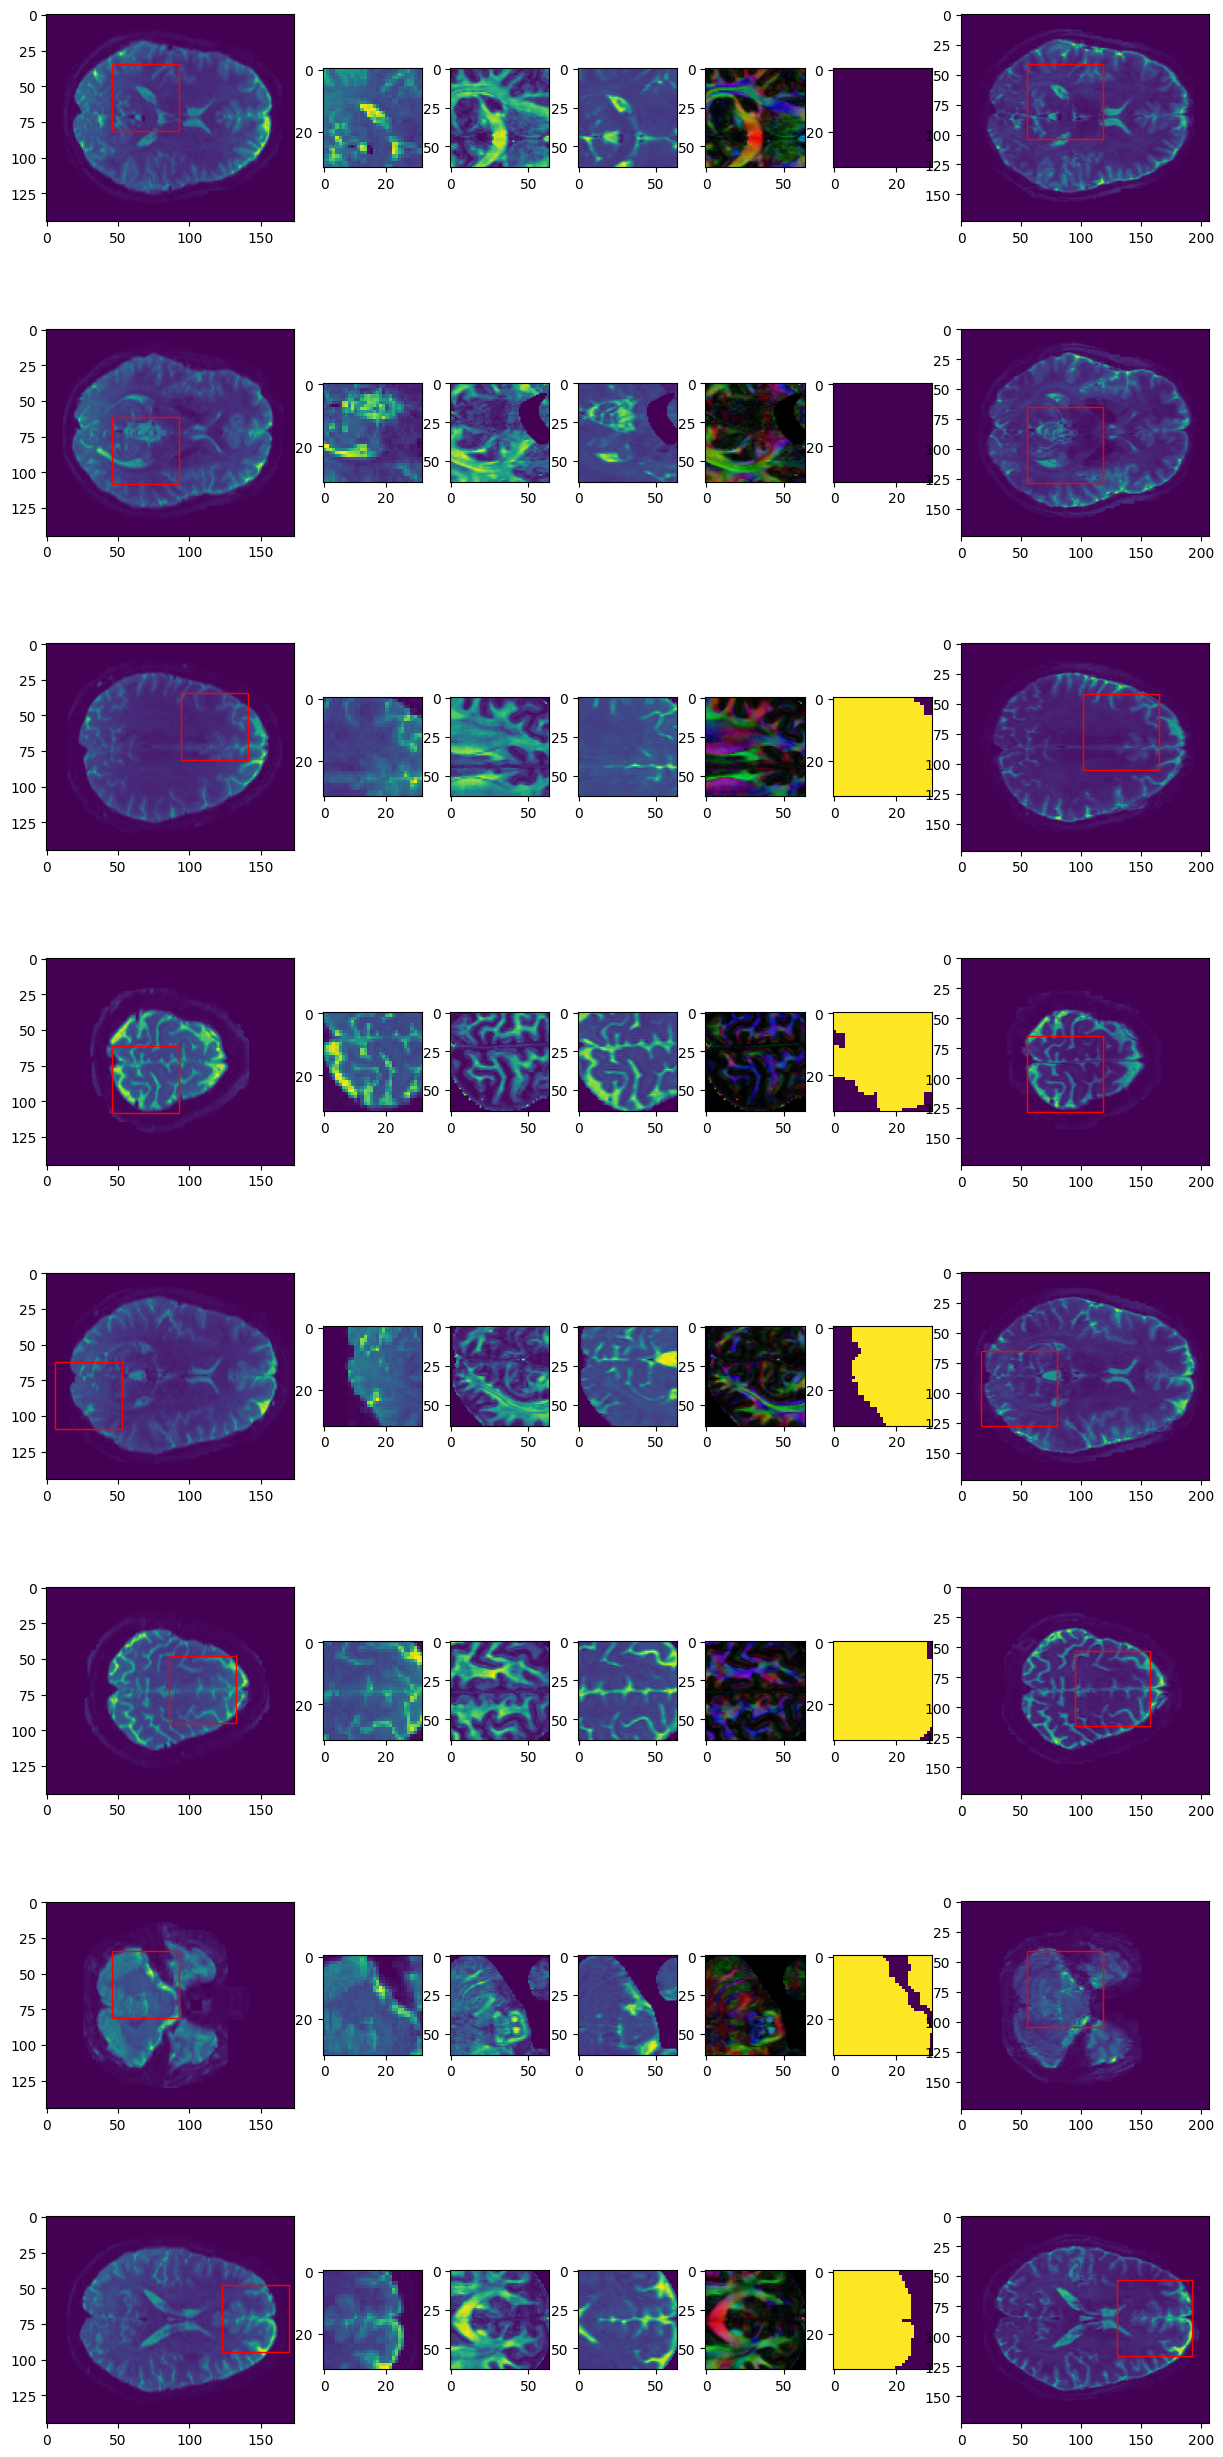

In [38]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

fig, ax = plt.subplots(l,7,gridspec_kw={'width_ratios': [2.5, 1,1,1,1,1,2.5]})

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(15)

for i in range(l):
    
    data_7t= loaded_gt[temp[3][i]]['vol0']
    data_3t= loaded[temp[3][i]]['vol0']
    img_pnt = temp[2][i]['lr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    
    ax[i][0].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][0].imshow(data_3t[:,:,sliceee,0])
    ax[i][1].imshow(temp[0][i,:,:,0,0])
    ax[i][2].imshow(temp[1][i,:,:,0,0])
    ax[i][3].imshow(temp[1][i,:,:,0,1])
    ax[i][4].imshow(temp[1][i,:,:,0,2:])
    ax[i][5].imshow(temp[0][i,:,:,0,7])
    
    img_pnt = temp[2][i]['hr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    ax[i][6].imshow(data_7t[:,:,sliceee,0])
    ax[i][6].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
plt.show()

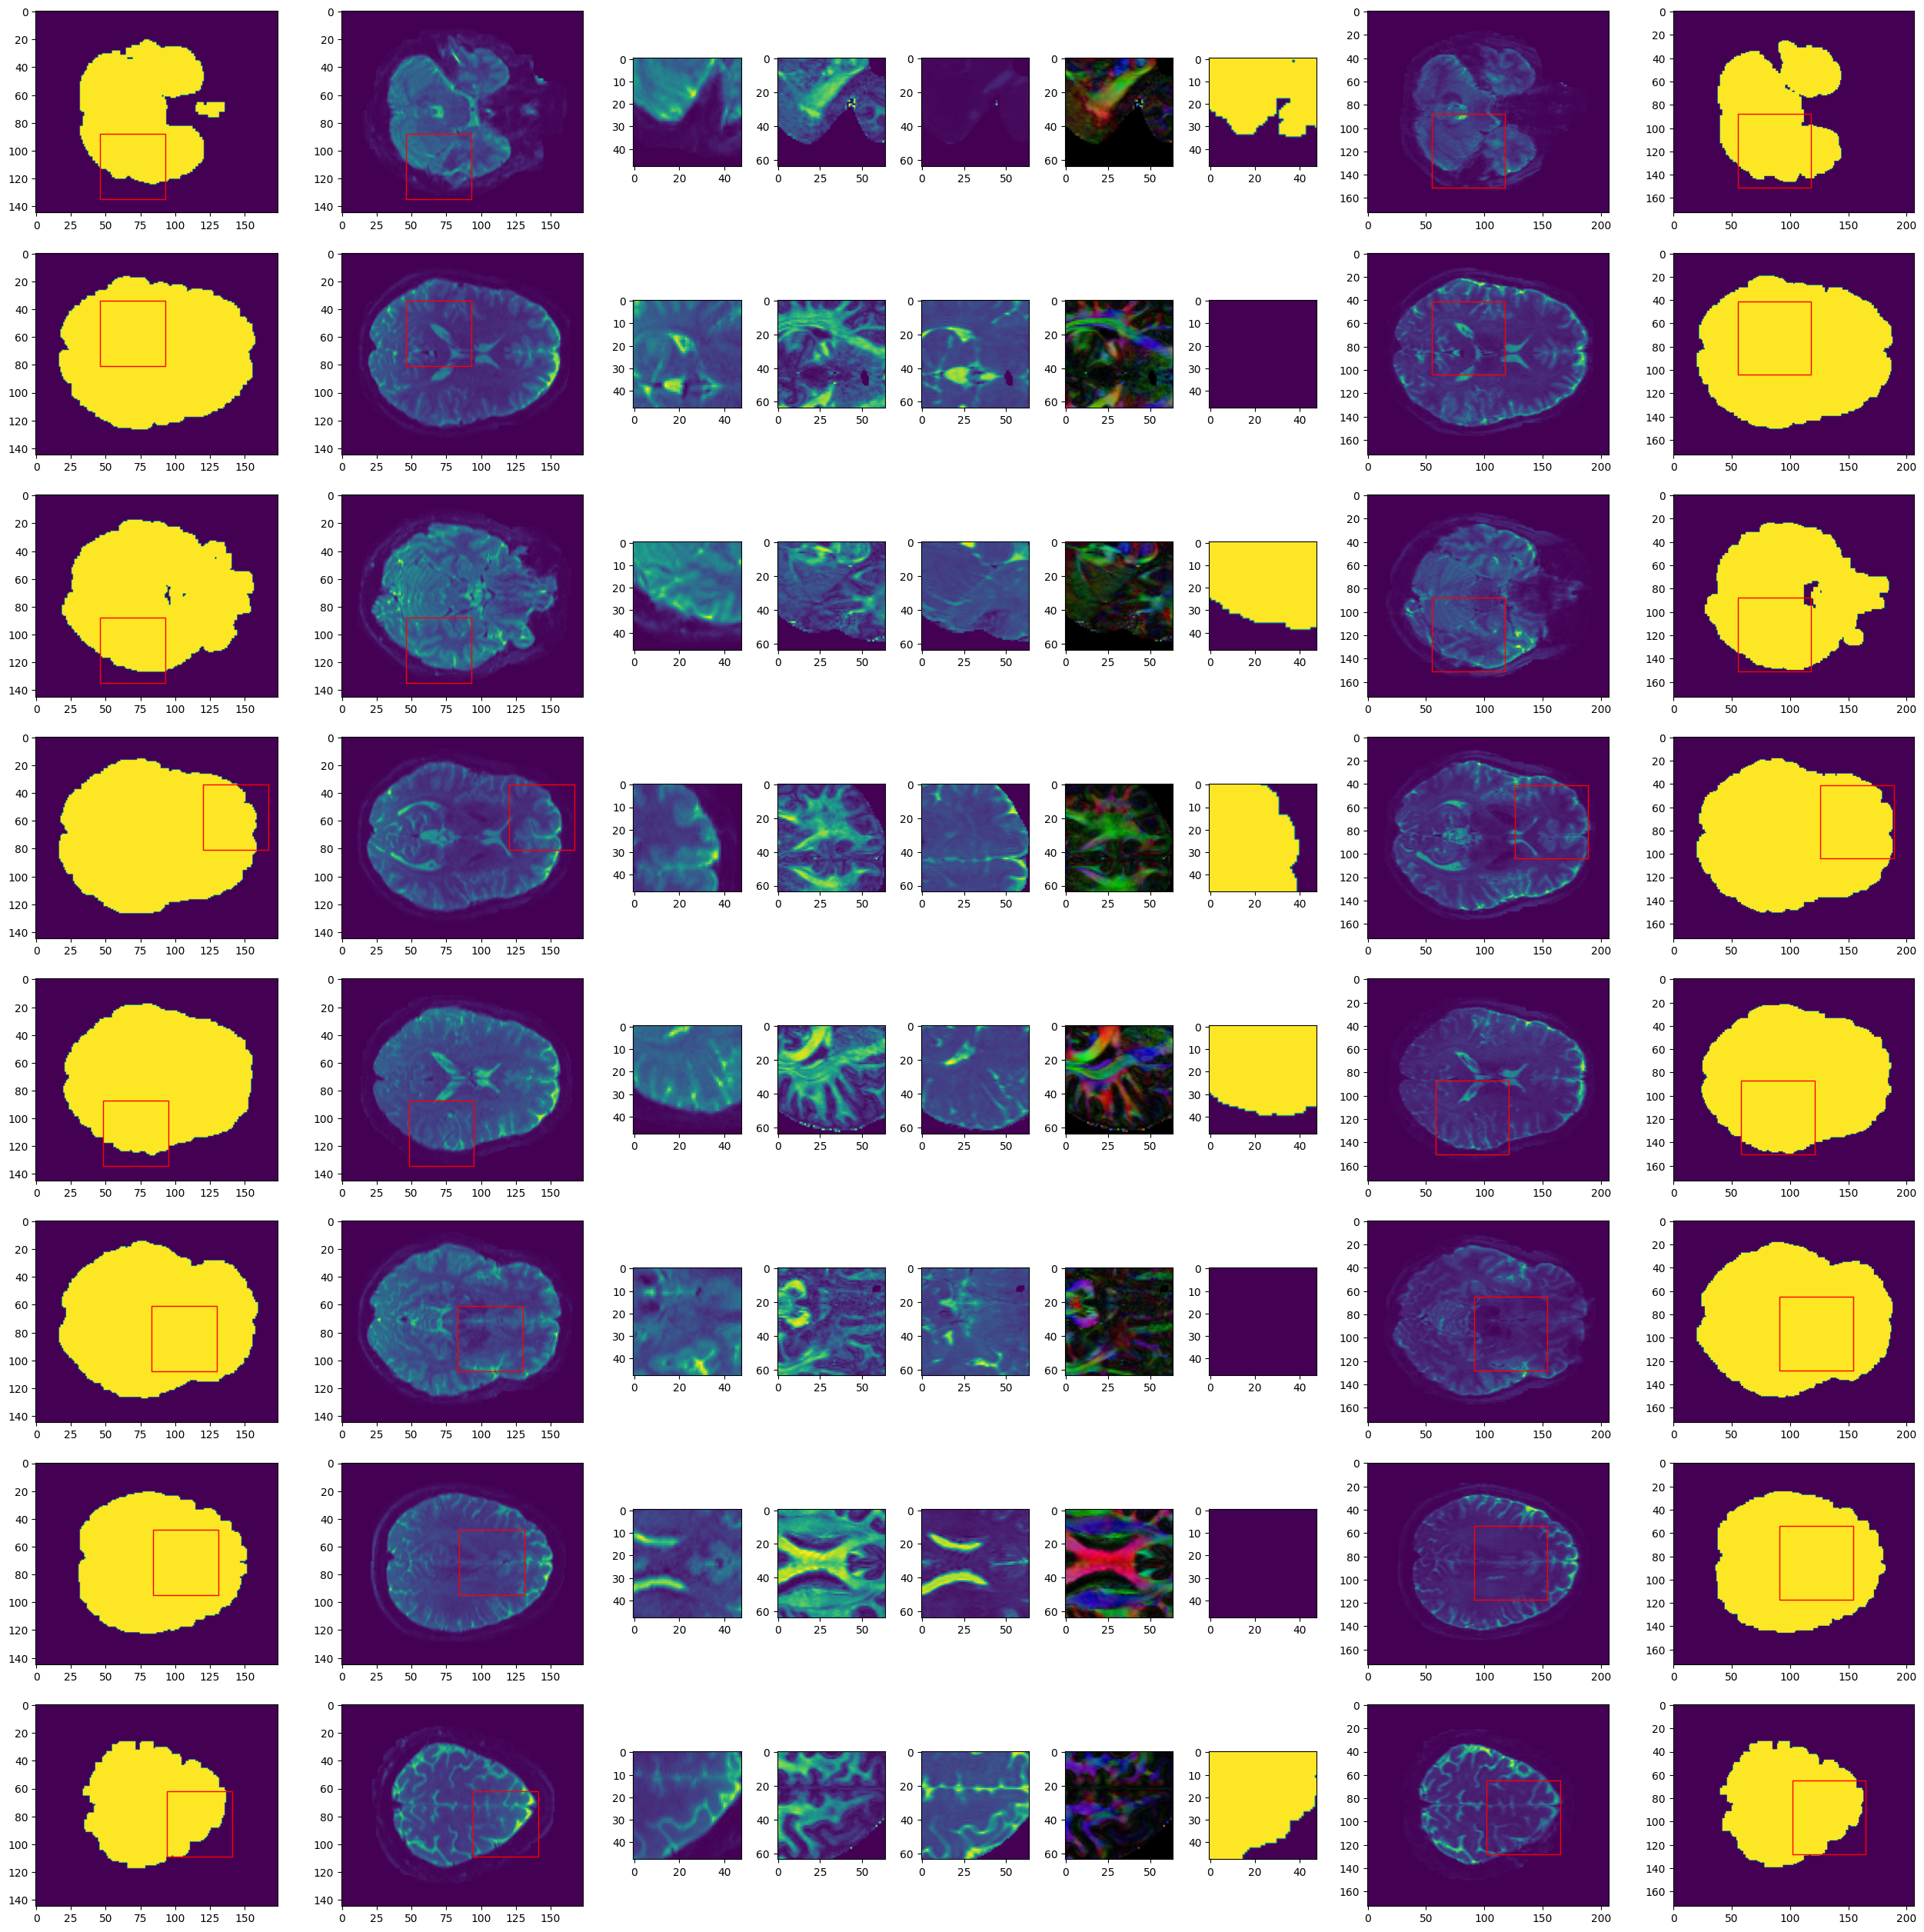

In [18]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

fig, ax = plt.subplots(l,9,gridspec_kw={'width_ratios': [2.5,2.5, 1,1,1,1,1,2.5,2.5]})

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(4*l)

for i in range(l):
    
    data_7t= loaded_gt[temp[3][i]]['vol0']
    data_7t_mask= loaded_gt[temp[3][i]]['mask']
    data_3t_mask= loaded[temp[3][i]]['mask']
    data_3t= loaded[temp[3][i]]['vol0']
    img_pnt = temp[2][i]['lr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    
    ax[i][0].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][0].imshow(data_3t_mask[:,:,sliceee])
    
    ax[i][1].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][1].imshow(data_3t[:,:,sliceee,0])
    ax[i][2].imshow(temp[0][i,:,:,0,0])
    ax[i][3].imshow(temp[1][i,:,:,0,0])
    ax[i][4].imshow(temp[1][i,:,:,0,1])
    ax[i][5].imshow(temp[1][i,:,:,0,2:])
    ax[i][6].imshow(temp[0][i,:,:,0,7])
    
    img_pnt = temp[2][i]['hr']
    y,x,w,d = img_pnt[0],img_pnt[2],int(img_pnt[1]-img_pnt[0]),int(img_pnt[3]-img_pnt[2])
    sliceee = ((img_pnt[5]-img_pnt[4])//2)+img_pnt[5]
    ax[i][7].imshow(data_7t[:,:,sliceee,0])
    ax[i][7].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][8].imshow(data_7t_mask[:,:,sliceee])
    ax[i][8].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
plt.show()

In [ ]:
ids